In [46]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from keras.datasets.mnist import load_data
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils


# define the standalone discriminator model
def define_discriminator(in_shape=(64, 64, 3), n_classes=40):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(40, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=40):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(40,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 4 * 4
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((4, 4, 40))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 4 * 4
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((4, 4, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # output
    out_layer = Conv2D(3, kernel_size=4, activation='tanh', padding='same', kernel_initializer=init)(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
    return model

def get_attributes(filename):
    attributes = pd.read_csv(filename)
    return np.array(attributes.drop('image_id', axis=1))[:how_many]
    '''
    return np.array(attributes[['No_Beard', 'Young', 'Attractive', 'Mouth_Slightly_Open', 'Smiling', 
                                'Wearing_Lipstick', 'High_Cheekbones', 'Male', 'Heavy_Makeup', 
                                'Wavy_Hair',
                               'Oval_Face',
                               'Pointy_Nose',
                               'Arched_Eyebrows']])[:how_many]'''
    

def load_dataset(dataset):
    X = []
    img_shape = (178, 218, 3)
    for i, myid in enumerate(dataset):
        image = load_img(directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    attributes = get_attributes(attr_file)
    attributes[attributes == -1] = 0 # replace label -1 to 0 for simplicity in generating random values later on
    return(X, attributes)

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, 40)) # HERE (n_samples, 40)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=32):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    print(n_steps)
    for i in range(n_steps):
        # get randomly selected ✬real✬ samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate ✬fake✬ examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator✬s error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, %d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (n_steps, i+1, d_r1,d_r2, d_f,d_f2,g_1,g_2))
        # evaluate the model performance every ✬epoch✬
        if (i+1) % (bat_per_epo * 10) == 0:
            g_model.save('models/cgan_generator' +str(i+j)+'.h5')
            model = load_model('models/cgan_generator' +str(i+j)+'.h5')
            latent_points, labels = generate_latent_points(100, 100)
            # specify labels
            labels = np.zeros((100,40)) # HERE (100, 40)
            labels[0][9] = 1 #blond
            # generate images
            X = g_model.predict([latent_points, labels])
            # scale from [-1,1] to [0,1]
            X = (X + 1) / 2.0
            save_plot(X, 5)


In [47]:
directory = 'img_align_celeba/img_align_celeba/'
attr_file = 'list_attr_celeba.csv'
how_many = 129
celeba_img = np.sort(os.listdir(directory))
dataset = celeba_img[:how_many]
img_shape = (178, 218, 3)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_dataset(dataset)

In [48]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

40


ValueError: Error when checking input: expected input_7 to have shape (28, 28, 1) but got array with shape (64, 64, 3)

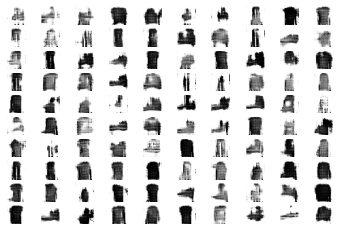

In [90]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, np.hstack((labels, labels)).reshape(n_samples, 2)]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
# load model
model = load_model('model_18750.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 2 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)